In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense

%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

## Data

In [2]:
df = pd.read_csv('../data/energy_data_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048346 entries, 0 to 1048345
Data columns (total 24 columns):
 #   Column                                     Non-Null Count    Dtype  
---  ------                                     --------------    -----  
 0   timestamp                                  1048346 non-null  object 
 1   square_feet                                1048346 non-null  float64
 2   year_built                                 1048346 non-null  float64
 3   floor_count                                1048346 non-null  float64
 4   air_temperature                            1048346 non-null  float64
 5   m2_per_floor                               1048346 non-null  float64
 6   target_lag_1                               1048346 non-null  float64
 7   target_lag_6                               1048346 non-null  float64
 8   target_lag_12                              1048346 non-null  float64
 9   target_lag_72                              1048346 non-null  float64

In [3]:
df = df.drop(['timestamp', 'year_built'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048346 entries, 0 to 1048345
Data columns (total 22 columns):
 #   Column                                     Non-Null Count    Dtype  
---  ------                                     --------------    -----  
 0   square_feet                                1048346 non-null  float64
 1   floor_count                                1048346 non-null  float64
 2   air_temperature                            1048346 non-null  float64
 3   m2_per_floor                               1048346 non-null  float64
 4   target_lag_1                               1048346 non-null  float64
 5   target_lag_6                               1048346 non-null  float64
 6   target_lag_12                              1048346 non-null  float64
 7   target_lag_72                              1048346 non-null  float64
 8   target_lag_120                             1048346 non-null  float64
 9   target_lag_168                             1048346 non-null  float64

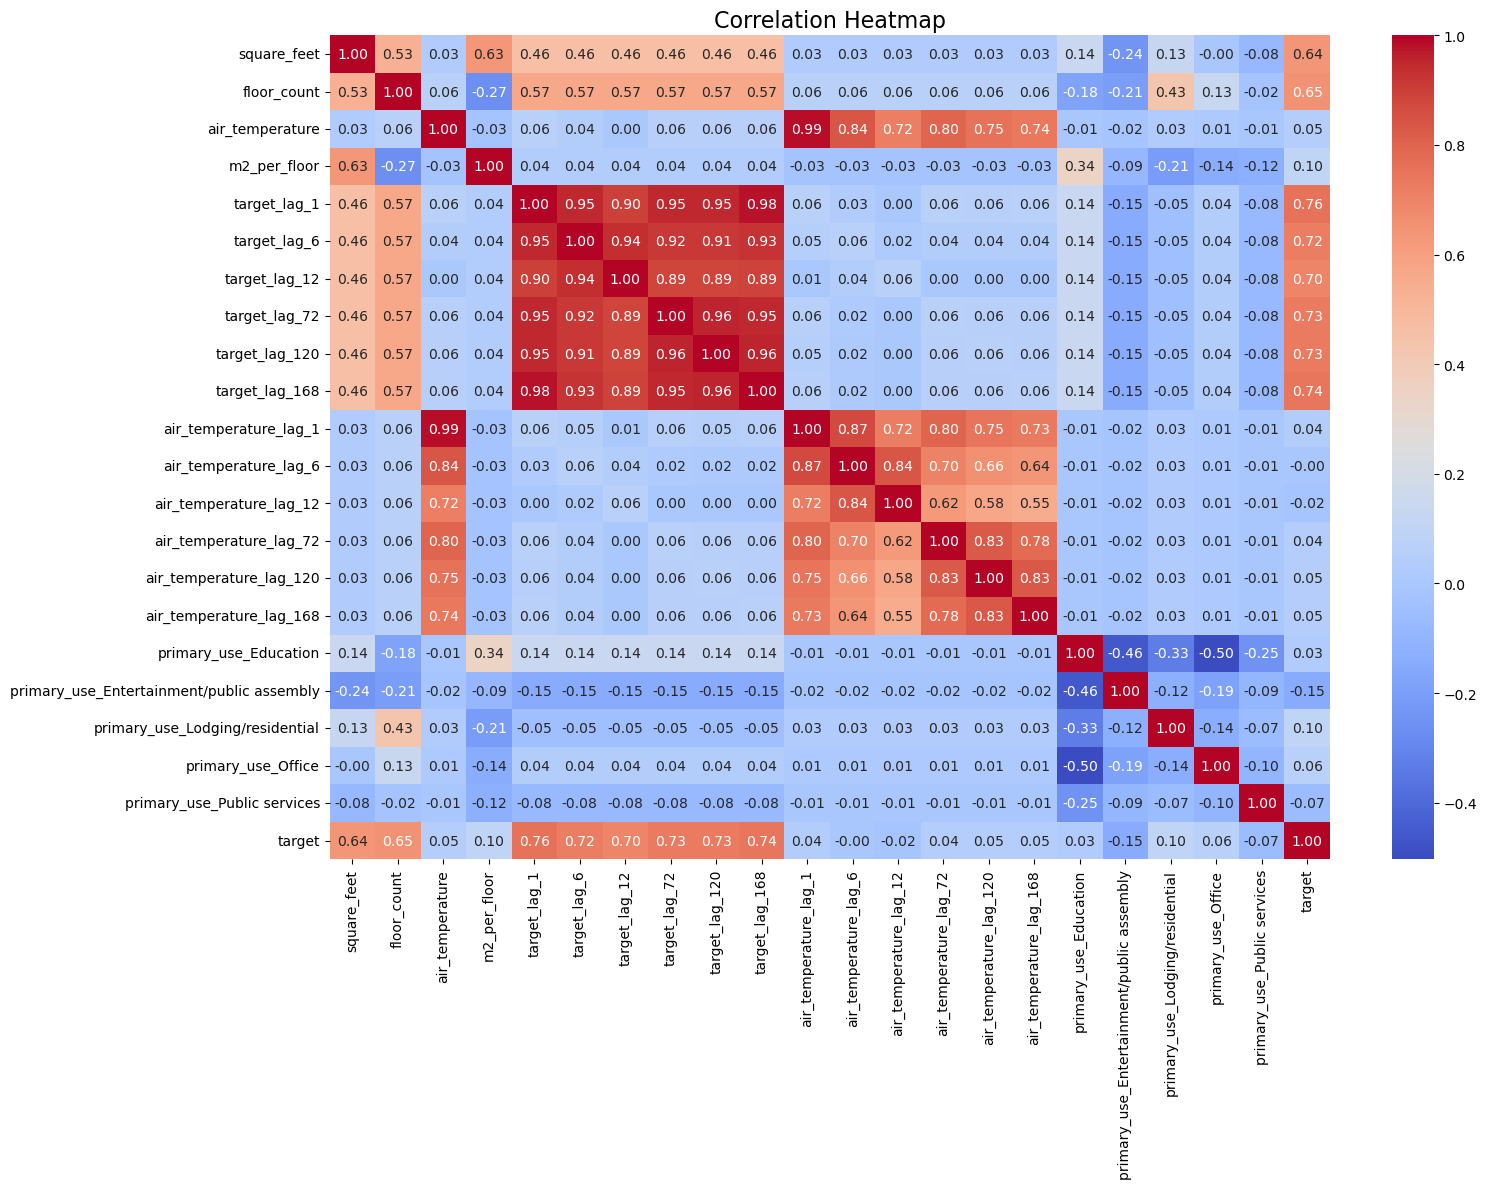

In [4]:
corr = df.corr() 
fig, ax = plt.subplots(figsize=(16, 12), dpi=100)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

## Preprocessing

In [5]:
X = df.drop('target', axis=1)
Y = df['target']

In [6]:
# 90% training, 10% test.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [7]:
# taking 10% of the training data for validation
num_validation_samples = int(0.15 * X_train.shape[0])  # Convert to Python int
X_val = X_train.iloc[:num_validation_samples]
y_val = y_train.iloc[:num_validation_samples]

X_train = X_train.iloc[num_validation_samples:]
y_train = y_train.iloc[num_validation_samples:]

In [8]:
print('70% training:', X_train.shape)
print('10% validation: ', X_val.shape)
print('10% test: ',X_test.shape)

70% training: (757430, 21)
10% validation:  (133664, 21)
10% test:  (157252, 21)


In [9]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

## Model

### Defining hyperparameters

In [10]:
HP_NUM_UNITS = hp.HParam('units', hp.Discrete([32, 64, 128]))
HP_REC_DROPOUT = hp.HParam('recurrent_dropout', hp.Discrete([0.0, 0.2]))

METRIC_MAE = 'MAE'
METRIC_MSE = 'MSE'
METRIC_RMSE = 'RMSE'
METRIC_R2 = 'R2'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_REC_DROPOUT],
    metrics=[hp.Metric(METRIC_MAE, display_name='MAE'),
             hp.Metric(METRIC_MSE, display_name='MSE'), 
             hp.Metric(METRIC_RMSE, display_name='RMSE'),
             hp.Metric(METRIC_R2, display_name='R2')]
  )

In [11]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

In [12]:
def train_test_model(log_dir, hparams, file_writer_cm=None):
  model = tf.keras.models.Sequential([
    Input(shape=((X_train_scaled.shape[1], 1))),
    LSTM(units=hparams[HP_NUM_UNITS], return_sequences=False, recurrent_dropout=hparams[HP_REC_DROPOUT]),
    Dense(units=1)
  ])
  
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', r2_metric])
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  model.fit(X_train_scaled, 
            y_train_scaled, 
            epochs=20, 
            batch_size=256, 
            validation_data=(X_val_scaled, y_val_scaled),
            callbacks=[tensorboard_callback],
            verbose=2
  )

  # Make predictions
  y_pred_scaled = model.predict(X_test_scaled)
  y_pred = scaler.inverse_transform(y_pred_scaled)
  y_test_orig = scaler.inverse_transform(y_test_scaled)

  # Test performance metrics
  mae = mean_absolute_error(y_test_orig, y_pred)
  mse = mean_squared_error(y_test_orig, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test_orig, y_pred)

  print(f'\nModel with hyperparameters:\nNum units: {hparams[HP_NUM_UNITS]}, rec. dropout: {hparams[HP_REC_DROPOUT]}\n   Test performance metrics:\n')
  print(f"    MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}\n")
  return mae, mse, rmse, r2


## Training the model with the different hyperparameters

In [13]:
# Creating a function to log the resuls
def run(log_dir, hparams):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        #file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
        mae, mse, rmse, r2 = train_test_model(log_dir, hparams)
        # register test performance metrics
        tf.summary.scalar(METRIC_MAE, mae, step=1)
        tf.summary.scalar(METRIC_MSE, mse, step=1)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
        tf.summary.scalar(METRIC_R2, r2, step=1)

In [14]:
# Performing a grid search on the hyperparameters we need to test
session_num = 0

for units in HP_NUM_UNITS.domain.values:
    for dropout in HP_REC_DROPOUT.domain.values:
        hparams = {
            HP_NUM_UNITS: units,
            HP_REC_DROPOUT: dropout
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        
        run('logs/hparam_tuning/' + run_name, hparams)

        session_num += 1

--- Starting trial: run-0
{'units': 32, 'recurrent_dropout': 0.0}
Epoch 1/20


2025-04-13 19:06:24.233397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-13 19:06:24.234964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-13 19:06:24.235811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2959/2959 - 35s - loss: 0.1397 - mae: 0.2533 - mse: 0.1397 - r2_metric: 0.8594 - val_loss: 0.0994 - val_mae: 0.2116 - val_mse: 0.0994 - val_r2_metric: 0.8994 - 35s/epoch - 12ms/step
Epoch 2/20
2959/2959 - 35s - loss: 0.0965 - mae: 0.2107 - mse: 0.0965 - r2_metric: 0.9028 - val_loss: 0.0934 - val_mae: 0.2042 - val_mse: 0.0934 - val_r2_metric: 0.9055 - 35s/epoch - 12ms/step
Epoch 3/20
2959/2959 - 34s - loss: 0.0903 - mae: 0.2040 - mse: 0.0903 - r2_metric: 0.9091 - val_loss: 0.0860 - val_mae: 0.1976 - val_mse: 0.0860 - val_r2_metric: 0.9130 - 34s/epoch - 11ms/step
Epoch 4/20
2959/2959 - 34s - loss: 0.0816 - mae: 0.1956 - mse: 0.0816 - r2_metric: 0.9178 - val_loss: 0.0768 - val_mae: 0.1890 - val_mse: 0.0768 - val_r2_metric: 0.9223 - 34s/epoch - 11ms/step
Epoch 5/20
2959/2959 - 34s - loss: 0.0717 - mae: 0.1827 - mse: 0.0717 - r2_metric: 0.9278 - val_loss: 0.0669 - val_mae: 0.1760 - val_mse: 0.0669 - val_r2_metric: 0.9322 - 34s/epoch - 11ms/step
Epoch 6/20
2959/2959 - 33s - loss: 0.0608 - ma

2025-04-13 19:17:37.130113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-13 19:17:37.130824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-13 19:17:37.131887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4915/4915 [==============================] - 7s 1ms/step

Model with hyperparameters:
Num units: 32, rec. dropout: 0.0
   Test performance metrics:

    MAE: 0.1259, MSE: 0.0492, RMSE: 0.2218, R2: 0.9814

--- Starting trial: run-1
{'units': 32, 'recurrent_dropout': 0.2}
Epoch 1/20
2959/2959 - 64s - loss: 0.1766 - mae: 0.2961 - mse: 0.1766 - r2_metric: 0.8223 - val_loss: 0.0998 - val_mae: 0.2172 - val_mse: 0.0998 - val_r2_metric: 0.8990 - 64s/epoch - 22ms/step
Epoch 2/20
2959/2959 - 63s - loss: 0.1008 - mae: 0.2242 - mse: 0.1008 - r2_metric: 0.8985 - val_loss: 0.0697 - val_mae: 0.1820 - val_mse: 0.0697 - val_r2_metric: 0.9294 - 63s/epoch - 21ms/step
Epoch 3/20
2959/2959 - 63s - loss: 0.0671 - mae: 0.1806 - mse: 0.0671 - r2_metric: 0.9324 - val_loss: 0.0335 - val_mae: 0.1181 - val_mse: 0.0335 - val_r2_metric: 0.9662 - 63s/epoch - 21ms/step
Epoch 4/20
2959/2959 - 63s - loss: 0.0421 - mae: 0.1388 - mse: 0.0421 - r2_metric: 0.9576 - val_loss: 0.0264 - val_mae: 0.0990 - val_mse: 0.0264 - val

2025-04-13 19:38:55.057995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-13 19:38:55.058953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-13 19:38:55.059765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2959/2959 - 69s - loss: 0.1347 - mae: 0.2481 - mse: 0.1347 - r2_metric: 0.8645 - val_loss: 0.0993 - val_mae: 0.2087 - val_mse: 0.0993 - val_r2_metric: 0.8996 - 69s/epoch - 23ms/step
Epoch 2/20
2959/2959 - 67s - loss: 0.0969 - mae: 0.2090 - mse: 0.0969 - r2_metric: 0.9023 - val_loss: 0.0938 - val_mae: 0.2023 - val_mse: 0.0938 - val_r2_metric: 0.9051 - 67s/epoch - 23ms/step
Epoch 3/20
2959/2959 - 66s - loss: 0.0884 - mae: 0.1993 - mse: 0.0884 - r2_metric: 0.9110 - val_loss: 0.0815 - val_mae: 0.1920 - val_mse: 0.0815 - val_r2_metric: 0.9175 - 66s/epoch - 22ms/step
Epoch 4/20
2959/2959 - 66s - loss: 0.0617 - mae: 0.1655 - mse: 0.0617 - r2_metric: 0.9378 - val_loss: 0.0407 - val_mae: 0.1324 - val_mse: 0.0407 - val_r2_metric: 0.9588 - 66s/epoch - 22ms/step
Epoch 5/20
2959/2959 - 64s - loss: 0.0335 - mae: 0.1173 - mse: 0.0335 - r2_metric: 0.9663 - val_loss: 0.0254 - val_mae: 0.0997 - val_mse: 0.0254 - val_r2_metric: 0.9744 - 64s/epoch - 22ms/step
Epoch 6/20
2959/2959 - 65s - loss: 0.0245 - ma

2025-04-13 20:00:42.277505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-13 20:00:42.278372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-13 20:00:42.279173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4915/4915 [==============================] - 10s 2ms/step

Model with hyperparameters:
Num units: 64, rec. dropout: 0.0
   Test performance metrics:

    MAE: 0.1208, MSE: 0.0426, RMSE: 0.2065, R2: 0.9839

--- Starting trial: run-3
{'units': 64, 'recurrent_dropout': 0.2}
Epoch 1/20
2959/2959 - 121s - loss: 0.1644 - mae: 0.2835 - mse: 0.1644 - r2_metric: 0.8345 - val_loss: 0.1048 - val_mae: 0.2205 - val_mse: 0.1048 - val_r2_metric: 0.8939 - 121s/epoch - 41ms/step
Epoch 2/20
2959/2959 - 122s - loss: 0.0969 - mae: 0.2187 - mse: 0.0969 - r2_metric: 0.9024 - val_loss: 0.0647 - val_mae: 0.1708 - val_mse: 0.0647 - val_r2_metric: 0.9345 - 122s/epoch - 41ms/step
Epoch 3/20
2959/2959 - 137s - loss: 0.0565 - mae: 0.1631 - mse: 0.0565 - r2_metric: 0.9430 - val_loss: 0.0275 - val_mae: 0.1073 - val_mse: 0.0275 - val_r2_metric: 0.9722 - 137s/epoch - 46ms/step
Epoch 4/20
2959/2959 - 136s - loss: 0.0326 - mae: 0.1193 - mse: 0.0326 - r2_metric: 0.9671 - val_loss: 0.0266 - val_mae: 0.1006 - val_mse: 0.02

2025-04-13 20:45:09.645708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-13 20:45:09.647202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-13 20:45:09.648093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2959/2959 - 138s - loss: 0.1340 - mae: 0.2516 - mse: 0.1340 - r2_metric: 0.8652 - val_loss: 0.1025 - val_mae: 0.2194 - val_mse: 0.1025 - val_r2_metric: 0.8963 - 138s/epoch - 47ms/step
Epoch 2/20
2959/2959 - 138s - loss: 0.0857 - mae: 0.2006 - mse: 0.0857 - r2_metric: 0.9137 - val_loss: 0.0572 - val_mae: 0.1603 - val_mse: 0.0572 - val_r2_metric: 0.9421 - 138s/epoch - 47ms/step
Epoch 3/20
2959/2959 - 139s - loss: 0.0427 - mae: 0.1352 - mse: 0.0427 - r2_metric: 0.9570 - val_loss: 0.0374 - val_mae: 0.1247 - val_mse: 0.0374 - val_r2_metric: 0.9621 - 139s/epoch - 47ms/step
Epoch 4/20
2959/2959 - 130s - loss: 0.0266 - mae: 0.1010 - mse: 0.0266 - r2_metric: 0.9732 - val_loss: 0.0236 - val_mae: 0.0936 - val_mse: 0.0236 - val_r2_metric: 0.9761 - 130s/epoch - 44ms/step
Epoch 5/20
2959/2959 - 131s - loss: 0.0227 - mae: 0.0908 - mse: 0.0227 - r2_metric: 0.9772 - val_loss: 0.0189 - val_mae: 0.0810 - val_mse: 0.0189 - val_r2_metric: 0.9809 - 131s/epoch - 44ms/step
Epoch 6/20
2959/2959 - 132s - loss: 

2025-04-13 21:29:30.671180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-13 21:29:30.672085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-13 21:29:30.672985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4915/4915 [==============================] - 17s 3ms/step

Model with hyperparameters:
Num units: 128, rec. dropout: 0.0
   Test performance metrics:

    MAE: 0.0954, MSE: 0.0325, RMSE: 0.1803, R2: 0.9877

--- Starting trial: run-5
{'units': 128, 'recurrent_dropout': 0.2}
Epoch 1/20
2959/2959 - 264s - loss: 0.1436 - mae: 0.2627 - mse: 0.1436 - r2_metric: 0.8555 - val_loss: 0.0947 - val_mae: 0.2154 - val_mse: 0.0947 - val_r2_metric: 0.9042 - 264s/epoch - 89ms/step
Epoch 2/20
2959/2959 - 269s - loss: 0.0697 - mae: 0.1801 - mse: 0.0697 - r2_metric: 0.9298 - val_loss: 0.0354 - val_mae: 0.1221 - val_mse: 0.0354 - val_r2_metric: 0.9643 - 269s/epoch - 91ms/step
Epoch 3/20
2959/2959 - 271s - loss: 0.0344 - mae: 0.1207 - mse: 0.0344 - r2_metric: 0.9654 - val_loss: 0.0202 - val_mae: 0.0871 - val_mse: 0.0202 - val_r2_metric: 0.9796 - 271s/epoch - 91ms/step
Epoch 4/20
2959/2959 - 264s - loss: 0.0230 - mae: 0.0941 - mse: 0.0230 - r2_metric: 0.9769 - val_loss: 0.0165 - val_mae: 0.0726 - val_mse: 0.

## Visualizing the hyperparameter results with Tensorboard

In [15]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/hparam_tuning"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
